# 0. Import (and install) libraries

In [1]:
!pip install graphviz
!pip install xgboost

In [2]:
import time
from datetime import datetime

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from graphviz import Source

from sklearn import tree, ensemble
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    confusion_matrix,
    roc_curve,
    auc
)
from xgboost import XGBClassifier

### 0.1. Setting random seed

Since we will be dealing with random processes, and we want them to be random but always the same, we should define the seed Python will use when going random.

In [16]:
random_state = 42

# 1. Import data

The dataset contains several timeseries extracted from the Iberian Power Market API: [esios](https://www.esios.ree.es/en)
* datetime: Timestamp in ISO format
* nuclear: nuclear power production
* ccgt: combined cycle power production (gas)
* demand: power demand
* hydro: hydro power production
* wind: wind power production
* solar: solar power production
* imbalance: whether the system needed to produce more energy to cover the the demand (1) or needed to produce less (-1)

In power systems, when demand is different than generation then the frequency goes crazy and affects every electric appliance. With that purpose in mind, when you are not producing/consuming what you settled on in the power market, you'll be penalized!

That's why we want to predict the sign: if we are able to predict whether the system will need more or less energy, we will not be penalized :)

In [3]:
data = pd.read_csv("power_market.csv")
data.head()

,datetime,nuclear,ccgt,demand,hydro,coal,wind,solar,imbalance_sign
0,2019-01-01T00:00:00.000+01:00,6047.360,3137.598,23459.000000,2581.529,1849.879,3794.191,15.986,1.0
1,2019-01-01T01:00:00.000+01:00,6045.900,3121.557,22781.000000,2556.662,1631.424,3767.804,15.921,1.0
2,2019-01-01T02:00:00.000+01:00,6046.754,3121.121,21448.500000,1840.314,1573.326,3757.543,8.272,-1.0
3,2019-01-01T03:00:00.000+01:00,6044.538,3609.398,20262.166667,1414.429,1441.022,3716.763,0.139,-1.0
4,2019-01-01T04:00:00.000+01:00,6045.747,3566.925,19463.500000,1535.409,1416.226,3532.569,0.233,-1.0


The goal for this forum is to train a model that predicts the sign of `imbalance` of the power system given the production of electricity per type and the demand of the system.

The imbalance is the amount of power that the country needs to increase/decrease in order to keep the power system stable and at the designed frequency of 50 Hz.

All the data displayed is in MWh (Mega Watt-hour).

# 2. Data analysis

In [5]:
data.dtypes

datetime           object
nuclear           float64
ccgt              float64
demand            float64
hydro             float64
coal              float64
wind              float64
solar             float64
imbalance_sign    float64
dtype: object

In [6]:
data.shape

(17544, 9)

In [7]:
data.describe()

,nuclear,ccgt,demand,hydro,coal,wind,solar,imbalance_sign
count,17544.000000,17544.000000,17544.000000,17544.00000,17544.000000,17544.000000,17544.000000,17544.000000
mean,6360.067396,5101.496615,27801.836506,3149.83397,881.841676,6091.862648,1905.609216,0.192202
std,913.782971,2906.496174,4656.921491,1641.10060,1016.261134,3599.947399,2384.556487,0.981383
min,3587.589000,324.927000,16542.500000,179.73200,-62.132000,127.783000,-0.600000,-1.000000
25%,5957.993500,2652.272750,24016.000000,1882.96975,396.630500,3272.826500,21.721250,-1.000000
50%,6920.351000,4621.532500,27683.416667,2835.76300,559.758000,5365.216000,601.510000,1.000000
75%,7084.553750,7154.293500,31414.416667,4115.68075,949.930500,8310.093250,3523.731500,1.000000
max,7129.239000,15059.735000,40149.666667,8665.56400,6375.439000,19354.967000,9101.684000,1.000000


Let's convert our target (`imbalance_sign`) into integer

In [4]:
# can you do this using other methods?
data["imbalance_sign"] = data["imbalance_sign"].apply(lambda x: int(x))

### 2.1. Training and test

Since we have timeseries, we can't split training and test using random sampling, so let's split according to dates.

Our `datetime` column is type `str` so let's convert it into a format understandable as a date. It also contains the timezone (`+01:00`, `+02:00`), so we can use the `datetime` native library to deal with this.

In [5]:
data["datetime"] = data["datetime"].apply(lambda x: datetime.fromisoformat(str(x))) 
data.head()

,datetime,nuclear,ccgt,demand,hydro,coal,wind,solar,imbalance_sign
0,2019-01-01 00:00:00+01:00,6047.360,3137.598,23459.000000,2581.529,1849.879,3794.191,15.986,1
1,2019-01-01 01:00:00+01:00,6045.900,3121.557,22781.000000,2556.662,1631.424,3767.804,15.921,1
2,2019-01-01 02:00:00+01:00,6046.754,3121.121,21448.500000,1840.314,1573.326,3757.543,8.272,-1
3,2019-01-01 03:00:00+01:00,6044.538,3609.398,20262.166667,1414.429,1441.022,3716.763,0.139,-1
4,2019-01-01 04:00:00+01:00,6045.747,3566.925,19463.500000,1535.409,1416.226,3532.569,0.233,-1


Now that we have our timestamp as a `datetime` object, let's extract some info from it: date, hour, weekend, etc

In [6]:
data["date"] = data["datetime"].apply(datetime.date)
data["hour"] = data["datetime"].apply(lambda x: int(x.strftime('%H')))
data["weekday"] = data["datetime"].apply(datetime.weekday)
data["weekend"] = np.where(
    data["weekday"] > 4,
    1, 
    0
)

Now it's converted we can split our data. How much data do we have?

In [7]:
data.datetime.apply(["min", "max"])

min   2019-01-01 00:00:00+01:00
max   2020-12-31 23:00:00+01:00
Name: datetime, dtype: datetime64[ns, UTC+01:00]

We have 2 years worth of data! Let's train with 75% of the data (approx until Aug2020) and predict on the 25% remaining 

Since we will be using this split later on, we should create a function to re-use

In [8]:
def train_test_split(data, date_split):

    # training vs target
    x = data.drop(["datetime", "imbalance_sign"], axis=1)
    y = data[["date", "imbalance_sign"]]

    # splitting data
    x_train = x[x["date"] < date_split].drop("date", axis=1)
    x_test = x[x["date"] >= date_split].drop("date", axis=1)
    y_train = y[y["date"] < date_split].drop("date", axis=1).values.ravel()
    y_test = y[y["date"] >= date_split].drop("date", axis=1).values.ravel()

    print(f"x_train: {x_train.shape}")
    print(f"x_test: {x_test.shape}")
    print(f"y_train: {y_train.shape}")
    print(f"y_test: {y_test.shape}")
    
    return x_train, x_test, y_train, y_test

date_split = pd.to_datetime("2020-07-01")
x_train, x_test, y_train, y_test = train_test_split(data, date_split)


x_train: (13127, 10)
x_test: (4417, 10)
y_train: (13127,)
y_test: (4417,)


In [10]:
# checking how balanced is our train data
train_classes, train_counts = np.unique(y_train, return_counts=True)
train_counts[0]/train_counts[1]

0.6848928250545501

In [11]:
# checking how balanced is our test data
test_classes, test_counts = np.unique(y_test, return_counts=True)
test_counts[0]/test_counts[1]

0.6561679790026247

The data is a bit unbalanced (class1/class2 = 0.65-0.68) but the distribution is more or less constant between train and test subsets

We're ready to go!

Before training, let's create a function that will plot several metrics, so we can compare methods:

In [14]:
def plot_roc(fpr, tpr, title="ROC Curve", note=""):
    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr)
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.title(title)
    if note: 
        plt.text(0.6, 0.2, note)
    plt.show()
    
    
def evaluation(y_test, y_hat):
    
    # metrics from sklearn
    fpr, tpr, thresholds = roc_curve(y_test, y_hat)
    auc_score = auc(fpr, tpr)
    confusion_mtx = confusion_matrix(y_test, y_hat, labels=np.unique(y_train))
    accuracy = accuracy_score(y_test, y_hat)
    precision = precision_score(y_test, y_hat)
    recall = recall_score(y_test, y_hat)
    
    # print metrics
    print(f"Accuracy: {accuracy:.3f}")
    print(f"Precision: {precision:.3f}")
    print(f"Recall: {recall:.3f}")
    print(f"Confusion matrix:") 
    print(confusion_mtx)

    # roc and auc
    title = "ROC"
    note = f"AUC = {auc_score:.3f}"
    plot_roc(fpr, tpr, title, note)

# 3. Decision tree

Let's train a simple tree: [DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)

The tree will grow until all leaves are pure or until they have 2 or less observations! 

In [18]:
dt = tree.DecisionTreeClassifier(random_state=random_state)  # without parameter turning
dt.fit(x_train, y_train)

DecisionTreeClassifier(random_state=42)

Evaluation metrics of our simple decision tree:

Accuracy: 0.553
Precision: 0.629
Recall: 0.632
Confusion matrix:
[[ 756  994]
 [ 982 1685]]


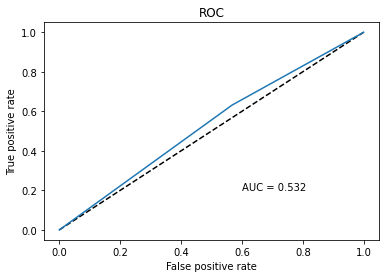

In [19]:
y_hat_1 = dt.predict(x_test)
evaluation(y_test, y_hat_1)  # using the function we created!

Slightly better than a coin flip... Let's see the importance our tree is assigning to each feature!

In [20]:
feat_imp = dt.feature_importances_
features = x_train.columns
feat_imp_dt = pd.DataFrame({
    "feature": features, 
    "importance": feat_imp
}).sort_values(by="importance", ascending=False).reset_index(drop=True)
feat_imp_dt

,feature,importance
0,nuclear,0.169669
1,wind,0.136487
2,coal,0.130452
3,hydro,0.123198
4,ccgt,0.117990
5,solar,0.099259
6,demand,0.091186
7,hour,0.067037
8,weekday,0.052242
9,weekend,0.012481


Nuclear power production seems to be the feature that's been used in more splits, therefore the one that better reduces the impurity!

### 3.1. Tuning parameters

The model is overfitting like hell, because it's trained to learn the training data by heart, but will not generalize enough to predict December2020 correctly.

In a tree-based algo, we can control several parameters, but two of them are quite important for handling overfitting:
* `max_depth`: the number of levels the tree will grow to

In [29]:
parameters = {
    "max_depth": 10,  # grow the tree until the 10th level
    "random_state": random_state
}

Accuracy: 0.579
Precision: 0.635
Recall: 0.712
Confusion matrix:
[[ 660 1090]
 [ 769 1898]]


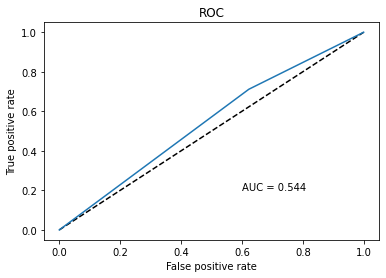

In [30]:
dt_tuning = tree.DecisionTreeClassifier(**parameters)  # we can pass a dictionary of parameters using ** (kwargs)
dt_tuning.fit(x_train, y_train)
y_hat_2 = dt_tuning.predict(x_test)
evaluation(y_test, y_hat_2)

It gets better! Seems like tuning these parameters was a good idea!

### 3.2. Check error in training vs test 

Changing `max_depth` was a good idea, since the tree didn't grow to the max. How can we know which is the best value?

Let's loop through several values of `max_depth` and see how the error in training vs test evolve!

max_depth: 1, acc_train: 0.594, acc_test=0.604
max_depth: 2, acc_train: 0.607, acc_test=0.581
max_depth: 3, acc_train: 0.618, acc_test=0.590
max_depth: 4, acc_train: 0.643, acc_test=0.596
max_depth: 5, acc_train: 0.658, acc_test=0.574
max_depth: 6, acc_train: 0.677, acc_test=0.597
max_depth: 7, acc_train: 0.698, acc_test=0.588
max_depth: 8, acc_train: 0.719, acc_test=0.594
max_depth: 9, acc_train: 0.748, acc_test=0.582
max_depth: 10, acc_train: 0.779, acc_test=0.579
max_depth: 11, acc_train: 0.808, acc_test=0.566
max_depth: 12, acc_train: 0.836, acc_test=0.573
max_depth: 13, acc_train: 0.868, acc_test=0.557
max_depth: 14, acc_train: 0.895, acc_test=0.561
max_depth: 15, acc_train: 0.918, acc_test=0.570
max_depth: 16, acc_train: 0.938, acc_test=0.544
max_depth: 17, acc_train: 0.955, acc_test=0.550
max_depth: 18, acc_train: 0.969, acc_test=0.547
max_depth: 19, acc_train: 0.982, acc_test=0.539
max_depth: 20, acc_train: 0.990, acc_test=0.552
max_depth: 21, acc_train: 0.995, acc_test=0.550
m

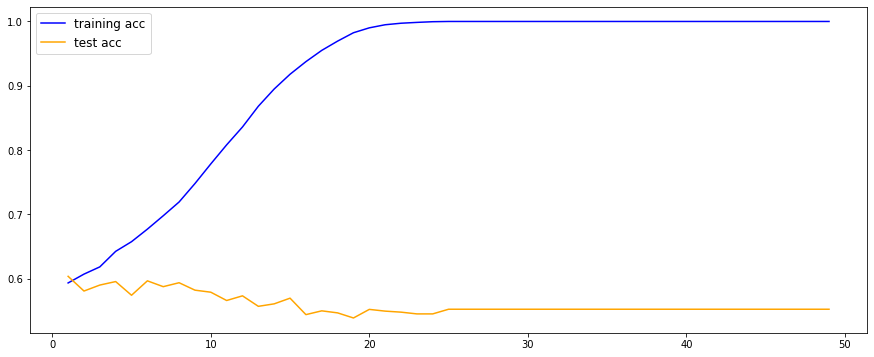

In [31]:
max_depth_range = range(1, 50)

error_results = []

# looping through values of max_depth
for max_depth in max_depth_range:
    
    # parameters
    parameters = {
        "max_depth": max_depth,
        "random_state": random_state
    }

    # train
    dt_2 = tree.DecisionTreeClassifier(**parameters)
    dt_2.fit(x_train, y_train)
    
    # predict
    y_hat_train = dt_2.predict(x_train)  # prediction on the training set
    y_hat_test = dt_2.predict(x_test)  # prediction on the test set
    
    # evaluate
    acc_train = accuracy_score(y_train, y_hat_train)  # accuracy achieved on the training data
    acc_test = accuracy_score(y_test, y_hat_test)  # accuracy achieved on the test data
    
    # store results
    error_results.append({
        "max_depth": max_depth, 
        "acc_train": acc_train,
        "acc_test": acc_test
    })
    
    # print evolution of loop:
    print(f"max_depth: {max_depth}, acc_train: {acc_train:.3f}, acc_test={acc_test:.3f}")
    
# saving results as dataframe
results = pd.DataFrame(error_results)

# plotting
fig, ax = plt.subplots(figsize=(15, 6))

ax.plot(results["max_depth"], results["acc_train"], label="training acc", color="blue")
ax.plot(results["max_depth"], results["acc_test"], label="test acc", color="orange")
ax.legend(fontsize=12)

plt.show()

### 3.3. Maybe we need some feature engineering?

In [32]:
data.head()

,datetime,nuclear,ccgt,demand,hydro,coal,wind,solar,imbalance_sign,date,hour,weekday,weekend
0,2019-01-01 00:00:00+01:00,6047.360,3137.598,23459.000000,2581.529,1849.879,3794.191,15.986,1,2019-01-01,0,1,0
1,2019-01-01 01:00:00+01:00,6045.900,3121.557,22781.000000,2556.662,1631.424,3767.804,15.921,1,2019-01-01,1,1,0
2,2019-01-01 02:00:00+01:00,6046.754,3121.121,21448.500000,1840.314,1573.326,3757.543,8.272,-1,2019-01-01,2,1,0
3,2019-01-01 03:00:00+01:00,6044.538,3609.398,20262.166667,1414.429,1441.022,3716.763,0.139,-1,2019-01-01,3,1,0
4,2019-01-01 04:00:00+01:00,6045.747,3566.925,19463.500000,1535.409,1416.226,3532.569,0.233,-1,2019-01-01,4,1,0


Somebody asked our colleagues in Portfolio Management, and they gave us some tips: 
* the difference between demand and total power production usually is important
* the ratios between each production and the demand (how much demand is covered by each type of production) are usually important
* total effect of renewable in the system (ratio renewable / demand)

In [33]:
data_feat_eng = data.copy()

# First set of new features: differences
production_features = ["nuclear", "ccgt", "hydro", "coal", "wind", "solar"]
data_feat_eng["production"] = data_feat_eng[production_features].sum(axis=1)
data_feat_eng["delta"] = data_feat_eng["demand"] - data_feat_eng["production"]

# Second set of features: ratios
for prod_type in production_features:
    data_feat_eng[f"ratio_{prod_type}_demand"] = data_feat_eng[prod_type] / data_feat_eng["demand"]
    
# bonus: total ratio of production / demand
data_feat_eng["ratio_production_demand"] = data_feat_eng["production"] / data_feat_eng["demand"]

# Third set of features: effect of renewables
data_feat_eng["ratio_renewables"] = (data_feat_eng["wind"] + data_feat_eng["solar"]) / data_feat_eng["demand"] 

# Bonus tip: thermal gap.
# This is the amount of demand that must be covered with fossil fuel technology
data_feat_eng["thermal_gap"] = (
    data_feat_eng["demand"] 
    - data_feat_eng["wind"] 
    - data_feat_eng["solar"] 
    - data_feat_eng["nuclear"]
)
data_feat_eng.head()

,datetime,nuclear,ccgt,demand,hydro,coal,wind,solar,imbalance_sign,date,...,delta,ratio_nuclear_demand,ratio_ccgt_demand,ratio_hydro_demand,ratio_coal_demand,ratio_wind_demand,ratio_solar_demand,ratio_production_demand,ratio_renewables,thermal_gap
0,2019-01-01 00:00:00+01:00,6047.360,3137.598,23459.000000,2581.529,1849.879,3794.191,15.986,1,2019-01-01,...,6032.457000,0.257784,0.133748,0.110044,0.078856,0.161737,0.000681,0.742851,0.162419,13601.463000
1,2019-01-01 01:00:00+01:00,6045.900,3121.557,22781.000000,2556.662,1631.424,3767.804,15.921,1,2019-01-01,...,5641.732000,0.265392,0.137025,0.112228,0.071613,0.165392,0.000699,0.752349,0.166091,12951.375000
2,2019-01-01 02:00:00+01:00,6046.754,3121.121,21448.500000,1840.314,1573.326,3757.543,8.272,-1,2019-01-01,...,5101.170000,0.281920,0.145517,0.085802,0.073354,0.175189,0.000386,0.762167,0.175575,11635.931000
3,2019-01-01 03:00:00+01:00,6044.538,3609.398,20262.166667,1414.429,1441.022,3716.763,0.139,-1,2019-01-01,...,4035.877667,0.298316,0.178135,0.069806,0.071119,0.183434,0.000007,0.800817,0.183441,10500.726667
4,2019-01-01 04:00:00+01:00,6045.747,3566.925,19463.500000,1535.409,1416.226,3532.569,0.233,-1,2019-01-01,...,3366.391000,0.310620,0.183262,0.078887,0.072763,0.181497,0.000012,0.827041,0.181509,9884.951000


Let's see now the training vs test error!

In [34]:
# recalculate training and test subsets with all the new features
x_train, x_test, y_train, y_test = train_test_split(data_feat_eng, date_split)

x_train: (13127, 21)
x_test: (4417, 21)
y_train: (13127,)
y_test: (4417,)


max_depth: 1, acc_train: 0.594, acc_test=0.604
max_depth: 2, acc_train: 0.614, acc_test=0.576
max_depth: 3, acc_train: 0.635, acc_test=0.587
max_depth: 4, acc_train: 0.649, acc_test=0.579
max_depth: 5, acc_train: 0.660, acc_test=0.575
max_depth: 6, acc_train: 0.678, acc_test=0.557
max_depth: 7, acc_train: 0.704, acc_test=0.553
max_depth: 8, acc_train: 0.730, acc_test=0.575
max_depth: 9, acc_train: 0.757, acc_test=0.564
max_depth: 10, acc_train: 0.784, acc_test=0.560
max_depth: 11, acc_train: 0.809, acc_test=0.555
max_depth: 12, acc_train: 0.840, acc_test=0.555
max_depth: 13, acc_train: 0.867, acc_test=0.556
max_depth: 14, acc_train: 0.896, acc_test=0.561
max_depth: 15, acc_train: 0.921, acc_test=0.558
max_depth: 16, acc_train: 0.939, acc_test=0.544
max_depth: 17, acc_train: 0.955, acc_test=0.549
max_depth: 18, acc_train: 0.967, acc_test=0.547
max_depth: 19, acc_train: 0.979, acc_test=0.542
max_depth: 20, acc_train: 0.985, acc_test=0.549
max_depth: 21, acc_train: 0.990, acc_test=0.554
m

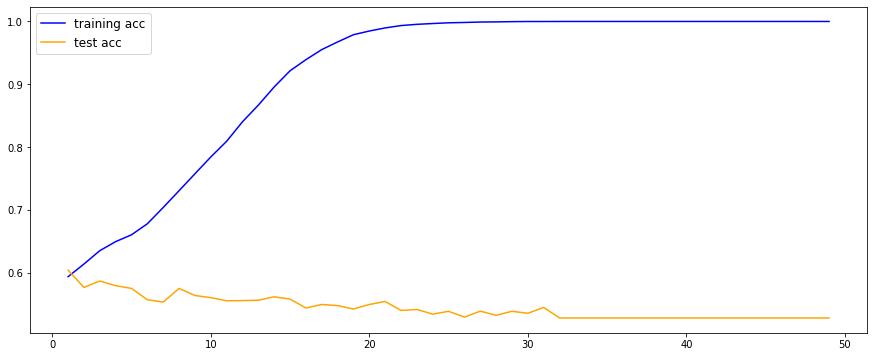

In [35]:
max_depth_range = range(1, 50)

error_results = []

# looping through values of max_depth
for max_depth in max_depth_range:
    
    # parameters
    parameters = {
        "max_depth": max_depth,
        "random_state": random_state
    }

    # train
    dt_2 = tree.DecisionTreeClassifier(**parameters)
    dt_2.fit(x_train, y_train)
    
    # predict
    y_hat_train = dt_2.predict(x_train)
    y_hat_test = dt_2.predict(x_test)
    
    # evaluate
    acc_train = accuracy_score(y_train, y_hat_train)
    acc_test = accuracy_score(y_test, y_hat_test)
    
    # store results
    error_results.append({
        "max_depth": max_depth, 
        "acc_train": acc_train,
        "acc_test": acc_test
    })
    
    # print evolution of loop:
    print(f"max_depth: {max_depth}, acc_train: {acc_train:.3f}, acc_test={acc_test:.3f}")
    
# saving results as dataframe
results = pd.DataFrame(error_results)

# plotting
fig, ax = plt.subplots(figsize=(15, 6))

ax.plot(results["max_depth"], results["acc_train"], label="training acc", color="blue")
ax.plot(results["max_depth"], results["acc_test"], label="test acc", color="orange")
ax.legend(fontsize=12)

plt.show()

Higher complexity (represented by `max_depth`) not always is equal to higher performance!
So What's the best value of `max_depth`? Train a Decision Tree with that value, and we calculate its Feature Importance

In [21]:
parameters = {
    "max_depth": 3,  # grow the tree until the 3rd level
    "random_state": random_state
}

Accuracy: 0.587
Precision: 0.624
Recall: 0.795
Confusion matrix:
[[ 471 1279]
 [ 547 2120]]


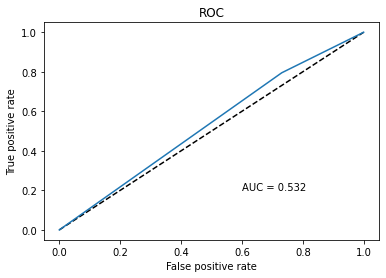

In [43]:
dt_tuning = tree.DecisionTreeClassifier(**parameters)  # we can pass a dictionary of parameters using ** (kwargs)
dt_tuning.fit(x_train, y_train)
y_hat_3 = dt_tuning.predict(x_test)
evaluation(y_test, y_hat_3)

In [46]:
feat_imp = dt_tuning.feature_importances_
features = x_train.columns
feat_imp_dt_tuning = pd.DataFrame({
    "feature": features, 
    "importance": feat_imp
}).sort_values(by="importance", ascending=False).reset_index(drop=True)
feat_imp_dt_tuning

,feature,importance
0,ratio_ccgt_demand,0.342689
1,ratio_hydro_demand,0.255485
2,nuclear,0.093842
3,hour,0.086682
4,wind,0.086532
5,ratio_renewables,0.069888
6,ratio_wind_demand,0.064882
7,ratio_nuclear_demand,0.000000
8,ratio_production_demand,0.000000
9,ratio_solar_demand,0.000000


Repeated what we just did with `max_depth` but this time with the parameter `min_sample_leaf`.

Read about it on the documentation: [DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)

In [70]:
parameters = {
    "max_depth": 3,  # grow the tree until the 10th level
    "random_state": random_state,
    "min_samples_leaf": 1000
}

Accuracy: 0.574
Precision: 0.606
Recall: 0.837
Confusion matrix:
[[ 301 1449]
 [ 434 2233]]


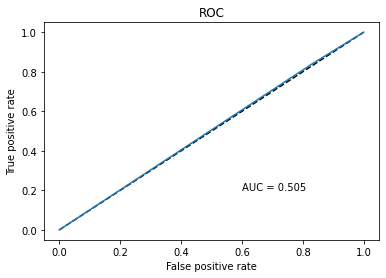

In [71]:
dt_tuning_leaf = tree.DecisionTreeClassifier(**parameters)  # we can pass a dictionary of parameters using ** (kwargs)
dt_tuning_leaf.fit(x_train, y_train)
y_hat_4 = dt_tuning_leaf.predict(x_test)
evaluation(y_test, y_hat_4)

min_samples_leaf: 1, acc_train: 0.635, acc_test=0.587
min_samples_leaf: 2, acc_train: 0.635, acc_test=0.587
min_samples_leaf: 3, acc_train: 0.635, acc_test=0.587
min_samples_leaf: 4, acc_train: 0.635, acc_test=0.587
min_samples_leaf: 5, acc_train: 0.635, acc_test=0.587
min_samples_leaf: 6, acc_train: 0.635, acc_test=0.587
min_samples_leaf: 7, acc_train: 0.635, acc_test=0.587
min_samples_leaf: 8, acc_train: 0.635, acc_test=0.587
min_samples_leaf: 9, acc_train: 0.635, acc_test=0.587
min_samples_leaf: 10, acc_train: 0.635, acc_test=0.587
min_samples_leaf: 11, acc_train: 0.635, acc_test=0.587
min_samples_leaf: 12, acc_train: 0.635, acc_test=0.587
min_samples_leaf: 13, acc_train: 0.635, acc_test=0.587
min_samples_leaf: 14, acc_train: 0.635, acc_test=0.587
min_samples_leaf: 15, acc_train: 0.635, acc_test=0.587
min_samples_leaf: 16, acc_train: 0.635, acc_test=0.587
min_samples_leaf: 17, acc_train: 0.635, acc_test=0.587
min_samples_leaf: 18, acc_train: 0.635, acc_test=0.587
min_samples_leaf: 1

min_samples_leaf: 150, acc_train: 0.635, acc_test=0.587
min_samples_leaf: 151, acc_train: 0.635, acc_test=0.587
min_samples_leaf: 152, acc_train: 0.635, acc_test=0.587
min_samples_leaf: 153, acc_train: 0.635, acc_test=0.587
min_samples_leaf: 154, acc_train: 0.635, acc_test=0.587
min_samples_leaf: 155, acc_train: 0.635, acc_test=0.587
min_samples_leaf: 156, acc_train: 0.635, acc_test=0.587
min_samples_leaf: 157, acc_train: 0.635, acc_test=0.587
min_samples_leaf: 158, acc_train: 0.635, acc_test=0.587
min_samples_leaf: 159, acc_train: 0.635, acc_test=0.587
min_samples_leaf: 160, acc_train: 0.635, acc_test=0.587
min_samples_leaf: 161, acc_train: 0.635, acc_test=0.587
min_samples_leaf: 162, acc_train: 0.635, acc_test=0.587
min_samples_leaf: 163, acc_train: 0.635, acc_test=0.587
min_samples_leaf: 164, acc_train: 0.635, acc_test=0.587
min_samples_leaf: 165, acc_train: 0.635, acc_test=0.587
min_samples_leaf: 166, acc_train: 0.635, acc_test=0.587
min_samples_leaf: 167, acc_train: 0.635, acc_tes

min_samples_leaf: 299, acc_train: 0.635, acc_test=0.587
min_samples_leaf: 300, acc_train: 0.635, acc_test=0.587
min_samples_leaf: 301, acc_train: 0.635, acc_test=0.587
min_samples_leaf: 302, acc_train: 0.635, acc_test=0.587
min_samples_leaf: 303, acc_train: 0.635, acc_test=0.587
min_samples_leaf: 304, acc_train: 0.635, acc_test=0.587
min_samples_leaf: 305, acc_train: 0.635, acc_test=0.587
min_samples_leaf: 306, acc_train: 0.635, acc_test=0.587
min_samples_leaf: 307, acc_train: 0.635, acc_test=0.587
min_samples_leaf: 308, acc_train: 0.635, acc_test=0.587
min_samples_leaf: 309, acc_train: 0.635, acc_test=0.587
min_samples_leaf: 310, acc_train: 0.635, acc_test=0.587
min_samples_leaf: 311, acc_train: 0.635, acc_test=0.587
min_samples_leaf: 312, acc_train: 0.635, acc_test=0.587
min_samples_leaf: 313, acc_train: 0.635, acc_test=0.587
min_samples_leaf: 314, acc_train: 0.635, acc_test=0.587
min_samples_leaf: 315, acc_train: 0.635, acc_test=0.587
min_samples_leaf: 316, acc_train: 0.635, acc_tes

min_samples_leaf: 446, acc_train: 0.637, acc_test=0.576
min_samples_leaf: 447, acc_train: 0.637, acc_test=0.576
min_samples_leaf: 448, acc_train: 0.637, acc_test=0.576
min_samples_leaf: 449, acc_train: 0.637, acc_test=0.576
min_samples_leaf: 450, acc_train: 0.637, acc_test=0.576
min_samples_leaf: 451, acc_train: 0.637, acc_test=0.576
min_samples_leaf: 452, acc_train: 0.637, acc_test=0.576
min_samples_leaf: 453, acc_train: 0.637, acc_test=0.576
min_samples_leaf: 454, acc_train: 0.637, acc_test=0.576
min_samples_leaf: 455, acc_train: 0.637, acc_test=0.576
min_samples_leaf: 456, acc_train: 0.637, acc_test=0.576
min_samples_leaf: 457, acc_train: 0.637, acc_test=0.576
min_samples_leaf: 458, acc_train: 0.637, acc_test=0.576
min_samples_leaf: 459, acc_train: 0.637, acc_test=0.576
min_samples_leaf: 460, acc_train: 0.637, acc_test=0.576
min_samples_leaf: 461, acc_train: 0.637, acc_test=0.576
min_samples_leaf: 462, acc_train: 0.637, acc_test=0.576
min_samples_leaf: 463, acc_train: 0.637, acc_tes

min_samples_leaf: 594, acc_train: 0.637, acc_test=0.576
min_samples_leaf: 595, acc_train: 0.637, acc_test=0.576
min_samples_leaf: 596, acc_train: 0.637, acc_test=0.576
min_samples_leaf: 597, acc_train: 0.637, acc_test=0.576
min_samples_leaf: 598, acc_train: 0.637, acc_test=0.576
min_samples_leaf: 599, acc_train: 0.637, acc_test=0.576
min_samples_leaf: 600, acc_train: 0.637, acc_test=0.576
min_samples_leaf: 601, acc_train: 0.637, acc_test=0.576
min_samples_leaf: 602, acc_train: 0.637, acc_test=0.576
min_samples_leaf: 603, acc_train: 0.637, acc_test=0.576
min_samples_leaf: 604, acc_train: 0.637, acc_test=0.576
min_samples_leaf: 605, acc_train: 0.637, acc_test=0.576
min_samples_leaf: 606, acc_train: 0.637, acc_test=0.576
min_samples_leaf: 607, acc_train: 0.637, acc_test=0.576
min_samples_leaf: 608, acc_train: 0.637, acc_test=0.576
min_samples_leaf: 609, acc_train: 0.637, acc_test=0.576
min_samples_leaf: 610, acc_train: 0.637, acc_test=0.576
min_samples_leaf: 611, acc_train: 0.637, acc_tes

min_samples_leaf: 742, acc_train: 0.637, acc_test=0.576
min_samples_leaf: 743, acc_train: 0.637, acc_test=0.576
min_samples_leaf: 744, acc_train: 0.637, acc_test=0.576
min_samples_leaf: 745, acc_train: 0.637, acc_test=0.576
min_samples_leaf: 746, acc_train: 0.637, acc_test=0.576
min_samples_leaf: 747, acc_train: 0.637, acc_test=0.576
min_samples_leaf: 748, acc_train: 0.637, acc_test=0.576
min_samples_leaf: 749, acc_train: 0.637, acc_test=0.576
min_samples_leaf: 750, acc_train: 0.637, acc_test=0.576
min_samples_leaf: 751, acc_train: 0.637, acc_test=0.576
min_samples_leaf: 752, acc_train: 0.637, acc_test=0.576
min_samples_leaf: 753, acc_train: 0.637, acc_test=0.576
min_samples_leaf: 754, acc_train: 0.637, acc_test=0.576
min_samples_leaf: 755, acc_train: 0.637, acc_test=0.576
min_samples_leaf: 756, acc_train: 0.637, acc_test=0.576
min_samples_leaf: 757, acc_train: 0.637, acc_test=0.576
min_samples_leaf: 758, acc_train: 0.637, acc_test=0.576
min_samples_leaf: 759, acc_train: 0.637, acc_tes

min_samples_leaf: 890, acc_train: 0.636, acc_test=0.573
min_samples_leaf: 891, acc_train: 0.636, acc_test=0.573
min_samples_leaf: 892, acc_train: 0.636, acc_test=0.573
min_samples_leaf: 893, acc_train: 0.636, acc_test=0.573
min_samples_leaf: 894, acc_train: 0.636, acc_test=0.573
min_samples_leaf: 895, acc_train: 0.636, acc_test=0.573
min_samples_leaf: 896, acc_train: 0.636, acc_test=0.573
min_samples_leaf: 897, acc_train: 0.636, acc_test=0.573
min_samples_leaf: 898, acc_train: 0.636, acc_test=0.573
min_samples_leaf: 899, acc_train: 0.636, acc_test=0.573
min_samples_leaf: 900, acc_train: 0.636, acc_test=0.573
min_samples_leaf: 901, acc_train: 0.636, acc_test=0.573
min_samples_leaf: 902, acc_train: 0.636, acc_test=0.573
min_samples_leaf: 903, acc_train: 0.636, acc_test=0.573
min_samples_leaf: 904, acc_train: 0.636, acc_test=0.573
min_samples_leaf: 905, acc_train: 0.636, acc_test=0.573
min_samples_leaf: 906, acc_train: 0.636, acc_test=0.573
min_samples_leaf: 907, acc_train: 0.625, acc_tes

min_samples_leaf: 1036, acc_train: 0.625, acc_test=0.574
min_samples_leaf: 1037, acc_train: 0.625, acc_test=0.574
min_samples_leaf: 1038, acc_train: 0.625, acc_test=0.574
min_samples_leaf: 1039, acc_train: 0.625, acc_test=0.574
min_samples_leaf: 1040, acc_train: 0.625, acc_test=0.574
min_samples_leaf: 1041, acc_train: 0.625, acc_test=0.574
min_samples_leaf: 1042, acc_train: 0.625, acc_test=0.574
min_samples_leaf: 1043, acc_train: 0.625, acc_test=0.574
min_samples_leaf: 1044, acc_train: 0.625, acc_test=0.574
min_samples_leaf: 1045, acc_train: 0.625, acc_test=0.574
min_samples_leaf: 1046, acc_train: 0.625, acc_test=0.574
min_samples_leaf: 1047, acc_train: 0.625, acc_test=0.574
min_samples_leaf: 1048, acc_train: 0.625, acc_test=0.574
min_samples_leaf: 1049, acc_train: 0.625, acc_test=0.574
min_samples_leaf: 1050, acc_train: 0.625, acc_test=0.574
min_samples_leaf: 1051, acc_train: 0.625, acc_test=0.574
min_samples_leaf: 1052, acc_train: 0.625, acc_test=0.574
min_samples_leaf: 1053, acc_tra

min_samples_leaf: 1181, acc_train: 0.624, acc_test=0.574
min_samples_leaf: 1182, acc_train: 0.624, acc_test=0.574
min_samples_leaf: 1183, acc_train: 0.624, acc_test=0.574
min_samples_leaf: 1184, acc_train: 0.624, acc_test=0.574
min_samples_leaf: 1185, acc_train: 0.624, acc_test=0.574
min_samples_leaf: 1186, acc_train: 0.624, acc_test=0.574
min_samples_leaf: 1187, acc_train: 0.624, acc_test=0.574
min_samples_leaf: 1188, acc_train: 0.624, acc_test=0.574
min_samples_leaf: 1189, acc_train: 0.624, acc_test=0.574
min_samples_leaf: 1190, acc_train: 0.624, acc_test=0.574
min_samples_leaf: 1191, acc_train: 0.624, acc_test=0.574
min_samples_leaf: 1192, acc_train: 0.624, acc_test=0.574
min_samples_leaf: 1193, acc_train: 0.624, acc_test=0.574
min_samples_leaf: 1194, acc_train: 0.624, acc_test=0.574
min_samples_leaf: 1195, acc_train: 0.624, acc_test=0.574
min_samples_leaf: 1196, acc_train: 0.624, acc_test=0.574
min_samples_leaf: 1197, acc_train: 0.624, acc_test=0.574
min_samples_leaf: 1198, acc_tra

min_samples_leaf: 1327, acc_train: 0.623, acc_test=0.574
min_samples_leaf: 1328, acc_train: 0.623, acc_test=0.574
min_samples_leaf: 1329, acc_train: 0.623, acc_test=0.574
min_samples_leaf: 1330, acc_train: 0.623, acc_test=0.574
min_samples_leaf: 1331, acc_train: 0.623, acc_test=0.574
min_samples_leaf: 1332, acc_train: 0.623, acc_test=0.574
min_samples_leaf: 1333, acc_train: 0.623, acc_test=0.574
min_samples_leaf: 1334, acc_train: 0.623, acc_test=0.574
min_samples_leaf: 1335, acc_train: 0.623, acc_test=0.574
min_samples_leaf: 1336, acc_train: 0.623, acc_test=0.574
min_samples_leaf: 1337, acc_train: 0.623, acc_test=0.574
min_samples_leaf: 1338, acc_train: 0.623, acc_test=0.574
min_samples_leaf: 1339, acc_train: 0.623, acc_test=0.574
min_samples_leaf: 1340, acc_train: 0.623, acc_test=0.574
min_samples_leaf: 1341, acc_train: 0.623, acc_test=0.574
min_samples_leaf: 1342, acc_train: 0.623, acc_test=0.574
min_samples_leaf: 1343, acc_train: 0.623, acc_test=0.574
min_samples_leaf: 1344, acc_tra

min_samples_leaf: 1472, acc_train: 0.622, acc_test=0.574
min_samples_leaf: 1473, acc_train: 0.622, acc_test=0.574
min_samples_leaf: 1474, acc_train: 0.622, acc_test=0.574
min_samples_leaf: 1475, acc_train: 0.622, acc_test=0.574
min_samples_leaf: 1476, acc_train: 0.622, acc_test=0.574
min_samples_leaf: 1477, acc_train: 0.622, acc_test=0.574
min_samples_leaf: 1478, acc_train: 0.622, acc_test=0.574
min_samples_leaf: 1479, acc_train: 0.622, acc_test=0.574
min_samples_leaf: 1480, acc_train: 0.622, acc_test=0.574
min_samples_leaf: 1481, acc_train: 0.622, acc_test=0.574
min_samples_leaf: 1482, acc_train: 0.622, acc_test=0.574
min_samples_leaf: 1483, acc_train: 0.622, acc_test=0.574
min_samples_leaf: 1484, acc_train: 0.622, acc_test=0.574
min_samples_leaf: 1485, acc_train: 0.622, acc_test=0.574
min_samples_leaf: 1486, acc_train: 0.622, acc_test=0.574
min_samples_leaf: 1487, acc_train: 0.622, acc_test=0.574
min_samples_leaf: 1488, acc_train: 0.622, acc_test=0.574
min_samples_leaf: 1489, acc_tra

min_samples_leaf: 1617, acc_train: 0.620, acc_test=0.579
min_samples_leaf: 1618, acc_train: 0.620, acc_test=0.579
min_samples_leaf: 1619, acc_train: 0.620, acc_test=0.579
min_samples_leaf: 1620, acc_train: 0.620, acc_test=0.579
min_samples_leaf: 1621, acc_train: 0.620, acc_test=0.579
min_samples_leaf: 1622, acc_train: 0.620, acc_test=0.579
min_samples_leaf: 1623, acc_train: 0.620, acc_test=0.579
min_samples_leaf: 1624, acc_train: 0.620, acc_test=0.579
min_samples_leaf: 1625, acc_train: 0.620, acc_test=0.579
min_samples_leaf: 1626, acc_train: 0.620, acc_test=0.579
min_samples_leaf: 1627, acc_train: 0.620, acc_test=0.579
min_samples_leaf: 1628, acc_train: 0.620, acc_test=0.579
min_samples_leaf: 1629, acc_train: 0.620, acc_test=0.579
min_samples_leaf: 1630, acc_train: 0.620, acc_test=0.579
min_samples_leaf: 1631, acc_train: 0.620, acc_test=0.579
min_samples_leaf: 1632, acc_train: 0.620, acc_test=0.579
min_samples_leaf: 1633, acc_train: 0.620, acc_test=0.579
min_samples_leaf: 1634, acc_tra

min_samples_leaf: 1762, acc_train: 0.620, acc_test=0.579
min_samples_leaf: 1763, acc_train: 0.620, acc_test=0.579
min_samples_leaf: 1764, acc_train: 0.620, acc_test=0.579
min_samples_leaf: 1765, acc_train: 0.620, acc_test=0.579
min_samples_leaf: 1766, acc_train: 0.620, acc_test=0.579
min_samples_leaf: 1767, acc_train: 0.620, acc_test=0.579
min_samples_leaf: 1768, acc_train: 0.620, acc_test=0.579
min_samples_leaf: 1769, acc_train: 0.620, acc_test=0.579
min_samples_leaf: 1770, acc_train: 0.620, acc_test=0.579
min_samples_leaf: 1771, acc_train: 0.620, acc_test=0.579
min_samples_leaf: 1772, acc_train: 0.620, acc_test=0.579
min_samples_leaf: 1773, acc_train: 0.620, acc_test=0.579
min_samples_leaf: 1774, acc_train: 0.620, acc_test=0.579
min_samples_leaf: 1775, acc_train: 0.620, acc_test=0.579
min_samples_leaf: 1776, acc_train: 0.620, acc_test=0.579
min_samples_leaf: 1777, acc_train: 0.620, acc_test=0.579
min_samples_leaf: 1778, acc_train: 0.620, acc_test=0.579
min_samples_leaf: 1779, acc_tra

min_samples_leaf: 1906, acc_train: 0.614, acc_test=0.581
min_samples_leaf: 1907, acc_train: 0.614, acc_test=0.581
min_samples_leaf: 1908, acc_train: 0.614, acc_test=0.581
min_samples_leaf: 1909, acc_train: 0.614, acc_test=0.581
min_samples_leaf: 1910, acc_train: 0.614, acc_test=0.581
min_samples_leaf: 1911, acc_train: 0.614, acc_test=0.581
min_samples_leaf: 1912, acc_train: 0.614, acc_test=0.581
min_samples_leaf: 1913, acc_train: 0.614, acc_test=0.581
min_samples_leaf: 1914, acc_train: 0.614, acc_test=0.581
min_samples_leaf: 1915, acc_train: 0.614, acc_test=0.581
min_samples_leaf: 1916, acc_train: 0.614, acc_test=0.581
min_samples_leaf: 1917, acc_train: 0.614, acc_test=0.581
min_samples_leaf: 1918, acc_train: 0.614, acc_test=0.581
min_samples_leaf: 1919, acc_train: 0.614, acc_test=0.581
min_samples_leaf: 1920, acc_train: 0.614, acc_test=0.581
min_samples_leaf: 1921, acc_train: 0.614, acc_test=0.581
min_samples_leaf: 1922, acc_train: 0.614, acc_test=0.581
min_samples_leaf: 1923, acc_tra

min_samples_leaf: 2051, acc_train: 0.613, acc_test=0.584
min_samples_leaf: 2052, acc_train: 0.613, acc_test=0.584
min_samples_leaf: 2053, acc_train: 0.613, acc_test=0.584
min_samples_leaf: 2054, acc_train: 0.613, acc_test=0.584
min_samples_leaf: 2055, acc_train: 0.613, acc_test=0.584
min_samples_leaf: 2056, acc_train: 0.613, acc_test=0.584
min_samples_leaf: 2057, acc_train: 0.613, acc_test=0.584
min_samples_leaf: 2058, acc_train: 0.613, acc_test=0.584
min_samples_leaf: 2059, acc_train: 0.613, acc_test=0.584
min_samples_leaf: 2060, acc_train: 0.613, acc_test=0.584
min_samples_leaf: 2061, acc_train: 0.613, acc_test=0.584
min_samples_leaf: 2062, acc_train: 0.613, acc_test=0.584
min_samples_leaf: 2063, acc_train: 0.613, acc_test=0.584
min_samples_leaf: 2064, acc_train: 0.613, acc_test=0.584
min_samples_leaf: 2065, acc_train: 0.613, acc_test=0.584
min_samples_leaf: 2066, acc_train: 0.613, acc_test=0.584
min_samples_leaf: 2067, acc_train: 0.613, acc_test=0.584
min_samples_leaf: 2068, acc_tra

min_samples_leaf: 2195, acc_train: 0.612, acc_test=0.586
min_samples_leaf: 2196, acc_train: 0.612, acc_test=0.586
min_samples_leaf: 2197, acc_train: 0.612, acc_test=0.586
min_samples_leaf: 2198, acc_train: 0.612, acc_test=0.586
min_samples_leaf: 2199, acc_train: 0.612, acc_test=0.586
min_samples_leaf: 2200, acc_train: 0.612, acc_test=0.586
min_samples_leaf: 2201, acc_train: 0.612, acc_test=0.586
min_samples_leaf: 2202, acc_train: 0.612, acc_test=0.586
min_samples_leaf: 2203, acc_train: 0.612, acc_test=0.586
min_samples_leaf: 2204, acc_train: 0.612, acc_test=0.586
min_samples_leaf: 2205, acc_train: 0.612, acc_test=0.586
min_samples_leaf: 2206, acc_train: 0.612, acc_test=0.586
min_samples_leaf: 2207, acc_train: 0.612, acc_test=0.586
min_samples_leaf: 2208, acc_train: 0.612, acc_test=0.586
min_samples_leaf: 2209, acc_train: 0.612, acc_test=0.586
min_samples_leaf: 2210, acc_train: 0.612, acc_test=0.586
min_samples_leaf: 2211, acc_train: 0.612, acc_test=0.586
min_samples_leaf: 2212, acc_tra

min_samples_leaf: 2341, acc_train: 0.612, acc_test=0.586
min_samples_leaf: 2342, acc_train: 0.612, acc_test=0.586
min_samples_leaf: 2343, acc_train: 0.612, acc_test=0.586
min_samples_leaf: 2344, acc_train: 0.612, acc_test=0.586
min_samples_leaf: 2345, acc_train: 0.612, acc_test=0.586
min_samples_leaf: 2346, acc_train: 0.612, acc_test=0.586
min_samples_leaf: 2347, acc_train: 0.612, acc_test=0.586
min_samples_leaf: 2348, acc_train: 0.612, acc_test=0.586
min_samples_leaf: 2349, acc_train: 0.612, acc_test=0.586
min_samples_leaf: 2350, acc_train: 0.612, acc_test=0.586
min_samples_leaf: 2351, acc_train: 0.612, acc_test=0.586
min_samples_leaf: 2352, acc_train: 0.612, acc_test=0.586
min_samples_leaf: 2353, acc_train: 0.612, acc_test=0.586
min_samples_leaf: 2354, acc_train: 0.612, acc_test=0.586
min_samples_leaf: 2355, acc_train: 0.612, acc_test=0.586
min_samples_leaf: 2356, acc_train: 0.612, acc_test=0.586
min_samples_leaf: 2357, acc_train: 0.612, acc_test=0.586
min_samples_leaf: 2358, acc_tra

min_samples_leaf: 2486, acc_train: 0.612, acc_test=0.586
min_samples_leaf: 2487, acc_train: 0.612, acc_test=0.586
min_samples_leaf: 2488, acc_train: 0.612, acc_test=0.586
min_samples_leaf: 2489, acc_train: 0.612, acc_test=0.586
min_samples_leaf: 2490, acc_train: 0.611, acc_test=0.586
min_samples_leaf: 2491, acc_train: 0.611, acc_test=0.586
min_samples_leaf: 2492, acc_train: 0.611, acc_test=0.588
min_samples_leaf: 2493, acc_train: 0.611, acc_test=0.588
min_samples_leaf: 2494, acc_train: 0.611, acc_test=0.588
min_samples_leaf: 2495, acc_train: 0.611, acc_test=0.588
min_samples_leaf: 2496, acc_train: 0.611, acc_test=0.588
min_samples_leaf: 2497, acc_train: 0.611, acc_test=0.588
min_samples_leaf: 2498, acc_train: 0.611, acc_test=0.588
min_samples_leaf: 2499, acc_train: 0.611, acc_test=0.588
min_samples_leaf: 2500, acc_train: 0.611, acc_test=0.588
min_samples_leaf: 2501, acc_train: 0.611, acc_test=0.588
min_samples_leaf: 2502, acc_train: 0.611, acc_test=0.588
min_samples_leaf: 2503, acc_tra

min_samples_leaf: 2630, acc_train: 0.611, acc_test=0.590
min_samples_leaf: 2631, acc_train: 0.611, acc_test=0.590
min_samples_leaf: 2632, acc_train: 0.611, acc_test=0.590
min_samples_leaf: 2633, acc_train: 0.611, acc_test=0.590
min_samples_leaf: 2634, acc_train: 0.611, acc_test=0.590
min_samples_leaf: 2635, acc_train: 0.611, acc_test=0.590
min_samples_leaf: 2636, acc_train: 0.611, acc_test=0.590
min_samples_leaf: 2637, acc_train: 0.611, acc_test=0.590
min_samples_leaf: 2638, acc_train: 0.611, acc_test=0.590
min_samples_leaf: 2639, acc_train: 0.611, acc_test=0.590
min_samples_leaf: 2640, acc_train: 0.611, acc_test=0.590
min_samples_leaf: 2641, acc_train: 0.611, acc_test=0.590
min_samples_leaf: 2642, acc_train: 0.611, acc_test=0.590
min_samples_leaf: 2643, acc_train: 0.611, acc_test=0.590
min_samples_leaf: 2644, acc_train: 0.611, acc_test=0.590
min_samples_leaf: 2645, acc_train: 0.611, acc_test=0.590
min_samples_leaf: 2646, acc_train: 0.611, acc_test=0.590
min_samples_leaf: 2647, acc_tra

min_samples_leaf: 2775, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 2776, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 2777, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 2778, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 2779, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 2780, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 2781, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 2782, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 2783, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 2784, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 2785, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 2786, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 2787, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 2788, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 2789, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 2790, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 2791, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 2792, acc_tra

min_samples_leaf: 2921, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 2922, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 2923, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 2924, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 2925, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 2926, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 2927, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 2928, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 2929, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 2930, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 2931, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 2932, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 2933, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 2934, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 2935, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 2936, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 2937, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 2938, acc_tra

min_samples_leaf: 3067, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 3068, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 3069, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 3070, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 3071, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 3072, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 3073, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 3074, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 3075, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 3076, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 3077, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 3078, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 3079, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 3080, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 3081, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 3082, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 3083, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 3084, acc_tra

min_samples_leaf: 3215, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 3216, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 3217, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 3218, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 3219, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 3220, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 3221, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 3222, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 3223, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 3224, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 3225, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 3226, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 3227, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 3228, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 3229, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 3230, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 3231, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 3232, acc_tra

min_samples_leaf: 3362, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 3363, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 3364, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 3365, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 3366, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 3367, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 3368, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 3369, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 3370, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 3371, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 3372, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 3373, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 3374, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 3375, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 3376, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 3377, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 3378, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 3379, acc_tra

min_samples_leaf: 3508, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 3509, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 3510, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 3511, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 3512, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 3513, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 3514, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 3515, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 3516, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 3517, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 3518, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 3519, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 3520, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 3521, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 3522, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 3523, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 3524, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 3525, acc_tra

min_samples_leaf: 3654, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 3655, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 3656, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 3657, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 3658, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 3659, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 3660, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 3661, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 3662, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 3663, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 3664, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 3665, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 3666, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 3667, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 3668, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 3669, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 3670, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 3671, acc_tra

min_samples_leaf: 3798, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 3799, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 3800, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 3801, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 3802, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 3803, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 3804, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 3805, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 3806, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 3807, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 3808, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 3809, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 3810, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 3811, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 3812, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 3813, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 3814, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 3815, acc_tra

min_samples_leaf: 3944, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 3945, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 3946, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 3947, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 3948, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 3949, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 3950, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 3951, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 3952, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 3953, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 3954, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 3955, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 3956, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 3957, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 3958, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 3959, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 3960, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 3961, acc_tra

min_samples_leaf: 4090, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 4091, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 4092, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 4093, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 4094, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 4095, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 4096, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 4097, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 4098, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 4099, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 4100, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 4101, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 4102, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 4103, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 4104, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 4105, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 4106, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 4107, acc_tra

min_samples_leaf: 4234, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 4235, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 4236, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 4237, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 4238, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 4239, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 4240, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 4241, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 4242, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 4243, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 4244, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 4245, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 4246, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 4247, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 4248, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 4249, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 4250, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 4251, acc_tra

min_samples_leaf: 4384, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 4385, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 4386, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 4387, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 4388, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 4389, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 4390, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 4391, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 4392, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 4393, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 4394, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 4395, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 4396, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 4397, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 4398, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 4399, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 4400, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 4401, acc_tra

min_samples_leaf: 4529, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 4530, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 4531, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 4532, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 4533, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 4534, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 4535, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 4536, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 4537, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 4538, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 4539, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 4540, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 4541, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 4542, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 4543, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 4544, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 4545, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 4546, acc_tra

min_samples_leaf: 4677, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 4678, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 4679, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 4680, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 4681, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 4682, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 4683, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 4684, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 4685, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 4686, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 4687, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 4688, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 4689, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 4690, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 4691, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 4692, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 4693, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 4694, acc_tra

min_samples_leaf: 4825, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 4826, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 4827, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 4828, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 4829, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 4830, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 4831, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 4832, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 4833, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 4834, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 4835, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 4836, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 4837, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 4838, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 4839, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 4840, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 4841, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 4842, acc_tra

min_samples_leaf: 4972, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 4973, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 4974, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 4975, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 4976, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 4977, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 4978, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 4979, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 4980, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 4981, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 4982, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 4983, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 4984, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 4985, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 4986, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 4987, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 4988, acc_train: 0.594, acc_test=0.604
min_samples_leaf: 4989, acc_tra

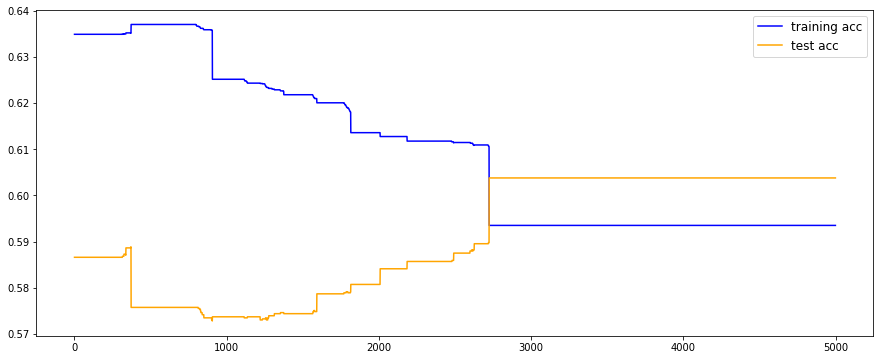

In [72]:
min_samples_leaf_range = range(1, 5000)

error_results = []

# looping through values of max_depth
for min_samp_leaf in min_samples_leaf_range:
    
    # parameters
    parameters = {
        "max_depth": 3,
        "random_state": random_state,
        "min_samples_leaf": min_samp_leaf
    }

    # train
    dt_3 = tree.DecisionTreeClassifier(**parameters)
    dt_3.fit(x_train, y_train)
    
    # predict
    y_hat_train = dt_3.predict(x_train)
    y_hat_test = dt_3.predict(x_test)
    
    # evaluate
    acc_train = accuracy_score(y_train, y_hat_train)
    acc_test = accuracy_score(y_test, y_hat_test)
    
    # store results
    error_results.append({
        "min_samples_leaf": min_samp_leaf, 
        "acc_train": acc_train,
        "acc_test": acc_test
    })
    
    # print evolution of loop:
    print(f"min_samples_leaf: {min_samp_leaf}, acc_train: {acc_train:.3f}, acc_test={acc_test:.3f}")
    
# saving results as dataframe
results = pd.DataFrame(error_results)

# plotting
fig, ax = plt.subplots(figsize=(15, 6))

ax.plot(results["min_samples_leaf"], results["acc_train"], label="training acc", color="blue")
ax.plot(results["min_samples_leaf"], results["acc_test"], label="test acc", color="orange")
ax.legend(fontsize=12)

plt.show()

# 4. Random Forest

Let's call the cavalry. By adding more trees to train on different samples of the same data, and averaging their outputs, we will gain robustness against overfitting.

Accuracy: 0.594
Precision: 0.655
Recall: 0.693
Confusion matrix:
[[ 775  975]
 [ 819 1848]]


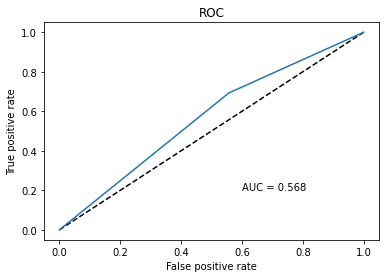

In [73]:
rf = ensemble.RandomForestClassifier(random_state=random_state)  # without parameter turning
rf.fit(x_train, y_train)
y_hat_5 = rf.predict(x_test)
evaluation(y_test, y_hat_5)

Better than the out-of-the-box DecisionTreeClassifier, but still not great...

Let's tune some parameters!

Accuracy: 0.602
Precision: 0.652
Recall: 0.733
Confusion matrix:
[[ 704 1046]
 [ 711 1956]]


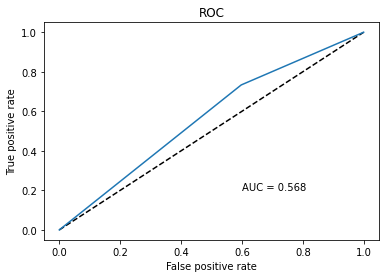

In [74]:
parameters = {
    "n_estimators": 30,  # 30 trees in total
    "max_depth": 15,  # each tree is limited to grow to the 15th lvel
    "max_features": 0.7,  # each tree will be trained only with a random sample of 70% of the features 
    "random_state": random_state 
}

rf = ensemble.RandomForestClassifier(**parameters) 
rf.fit(x_train, y_train)
y_hat_4 = rf.predict(x_test)
evaluation(y_test, y_hat_4)

N_trees: 1, acc_train: 0.884, acc_test=0.540
N_trees: 6, acc_train: 0.975, acc_test=0.562
N_trees: 11, acc_train: 0.993, acc_test=0.579
N_trees: 16, acc_train: 0.996, acc_test=0.570
N_trees: 21, acc_train: 0.998, acc_test=0.588
N_trees: 26, acc_train: 0.999, acc_test=0.577
N_trees: 31, acc_train: 1.000, acc_test=0.584
N_trees: 36, acc_train: 1.000, acc_test=0.583
N_trees: 41, acc_train: 1.000, acc_test=0.583
N_trees: 46, acc_train: 1.000, acc_test=0.585
N_trees: 51, acc_train: 1.000, acc_test=0.589
N_trees: 56, acc_train: 1.000, acc_test=0.584
N_trees: 61, acc_train: 1.000, acc_test=0.587
N_trees: 66, acc_train: 1.000, acc_test=0.584
N_trees: 71, acc_train: 1.000, acc_test=0.589
N_trees: 76, acc_train: 1.000, acc_test=0.586
N_trees: 81, acc_train: 1.000, acc_test=0.590
N_trees: 86, acc_train: 1.000, acc_test=0.591
N_trees: 91, acc_train: 1.000, acc_test=0.593
N_trees: 96, acc_train: 1.000, acc_test=0.591


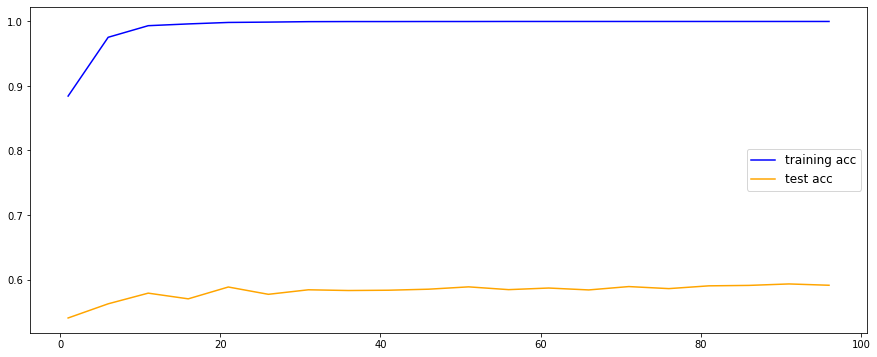

In [75]:
trees_range = range(1, 100, 5)

error_results = []

# looping through values of max_depth
for i, trees in enumerate(trees_range):
    
    # train
    rf = ensemble.RandomForestClassifier(n_estimators=trees, random_state=random_state)
    rf.fit(x_train, y_train)
    
    # predict
    y_hat_train = rf.predict(x_train)
    y_hat_test = rf.predict(x_test)
    
    # evaluate
    acc_train = accuracy_score(y_train, y_hat_train)
    acc_test = accuracy_score(y_test, y_hat_test)
    
    # store results
    error_results.append({
        "n_trees": trees, 
        "acc_train": acc_train,
        "acc_test": acc_test
    })
    
    # print evolution of loop:
    print(f"N_trees: {trees}, acc_train: {acc_train:.3f}, acc_test={acc_test:.3f}")
    
# saving results as dataframe
results = pd.DataFrame(error_results)

# plotting
fig, ax = plt.subplots(figsize=(15, 6))

ax.plot(results["n_trees"], results["acc_train"], label="training acc", color="blue")
ax.plot(results["n_trees"], results["acc_test"], label="test acc", color="orange")
ax.legend(fontsize=12)

plt.show()

Our RandomForest seems to have learned everything about the training data with ~30 trees, after that both `train`and `test` accuracy stay flat.

In this case, 20 trees seem to be the optimal complexity, since the peak in test accuracy happens around 20. We can increase the number of trees but we should make each tree to `learn` less by reducing for example the amount of data (`max_features`) each tree is fed or by reducing the `max_depth` of each tree.

Let's repeat the exercise with 20 trees but now changing the `max_feature` and `max_depth` parameters!

This we're doing can be done automatically with `sklearn`'s [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)

In [76]:
pct_features = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
max_depths = [1, 2, 3, 4, 5, 10, 15, 20]
n_trees = 20
error_results = []
results_mtx = np.zeros((len(max_depths), len(pct_features)))

# looping through values of max_depth
for i, max_depth in enumerate(max_depths):
    for j, pct in enumerate(pct_features):
    
        # train
        rf = ensemble.RandomForestClassifier(
            n_estimators=n_trees, 
            random_state=random_state,
            max_depth=max_depth,
            max_features=pct
        )
        rf.fit(x_train, y_train)

        # predict
        y_hat_train = rf.predict(x_train)
        y_hat_test = rf.predict(x_test)

        # evaluate
        acc_train = accuracy_score(y_train, y_hat_train)
        acc_test = accuracy_score(y_test, y_hat_test)
        results_mtx[i, j] = acc_test

        # store results
        error_results.append({
            "pct_features": pct, 
            "max_depth": max_depth,
            "acc_train": acc_train,
            "acc_test": acc_test
        })

        # print evolution of loop:
        print(f"Max_features: {pct}, max_depth: {max_depth}, acc_train: {acc_train:.3f}, acc_test={acc_test:.3f}")
    
# saving results as dataframe
results = pd.DataFrame(error_results)

Max_features: 0.1, max_depth: 1, acc_train: 0.594, acc_test=0.604
Max_features: 0.2, max_depth: 1, acc_train: 0.594, acc_test=0.604
Max_features: 0.3, max_depth: 1, acc_train: 0.594, acc_test=0.604
Max_features: 0.4, max_depth: 1, acc_train: 0.594, acc_test=0.604
Max_features: 0.5, max_depth: 1, acc_train: 0.594, acc_test=0.604
Max_features: 0.6, max_depth: 1, acc_train: 0.594, acc_test=0.604
Max_features: 0.7, max_depth: 1, acc_train: 0.594, acc_test=0.604
Max_features: 0.8, max_depth: 1, acc_train: 0.594, acc_test=0.604
Max_features: 0.9, max_depth: 1, acc_train: 0.594, acc_test=0.604
Max_features: 0.1, max_depth: 2, acc_train: 0.598, acc_test=0.602
Max_features: 0.2, max_depth: 2, acc_train: 0.604, acc_test=0.599
Max_features: 0.3, max_depth: 2, acc_train: 0.615, acc_test=0.598
Max_features: 0.4, max_depth: 2, acc_train: 0.613, acc_test=0.596
Max_features: 0.5, max_depth: 2, acc_train: 0.614, acc_test=0.594
Max_features: 0.6, max_depth: 2, acc_train: 0.622, acc_test=0.597
Max_featur

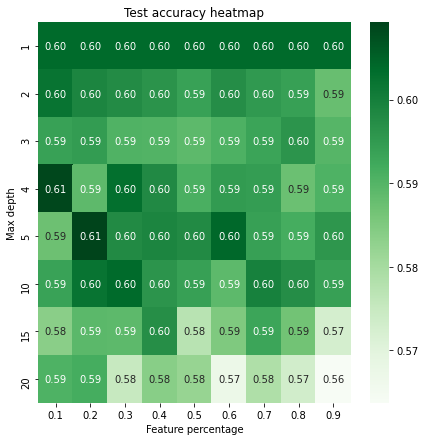

In [77]:
# plotting
fig, ax = plt.subplots(figsize=(7, 7))

sns.heatmap(
    results_mtx, 
    ax=ax, 
    xticklabels=np.round(pct_features, 2), 
    yticklabels=np.round(max_depths, 2),
    annot=True,
    fmt=".2f",
    cmap="Greens"
)
ax.set_title("Test accuracy heatmap")
ax.set_xlabel("Feature percentage")
ax.set_ylabel("Max depth")

plt.show()

It looks like the sweet spot revolves around 4-5 levels of depth, while using 10-20 % of the features for each tree.

Accuracy test is 61 % in the sweet spot!

# 5. XGBoost

And finally: [XGBoost](https://xgboost.readthedocs.io/en/latest/parameter.html). 

Will use xgb first out of the box, and then will tune it a bit.

Xgb needs the classes to be [0, 1, 2, etc] so let's convert our `y` subsets:

In [79]:
y_train = np.where(y_train==1, 1, 0)
y_test = np.where(y_test==1, 1, 0)
y_train

array([1, 1, 0, ..., 1, 1, 1])

`XGBoost` uses the same syntax as `scikit-learn` for training and predicting, which is quite useful.

[15:17:46] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 0.594
Precision: 0.648
Recall: 0.716
Confusion matrix:
[[ 713 1037]
 [ 757 1910]]


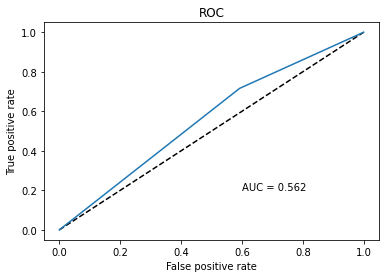

In [32]:
xgb = XGBClassifier(use_label_encoder=False, objective='binary:logistic')
xgb.fit(x_train, y_train)
y_hat_xgb = xgb.predict(x_test)
evaluation(y_test, y_hat_xgb)

Almost as good as the tuned Random Forest! Let's pull more levers by tuning some parameters of the estimator.

In [80]:
xgb_tuned = XGBClassifier(
    use_label_encoder=False, # labels are already encoded as [0, 1]
    objective='binary:logistic', # for binary classification
    max_depth=5,  # depth of each tree
    subsample=0.3,  # sample of training data each tree will use: 30 %
    n_estimators=500,  # total number of trees that will be created
    learning_rate=0.01  # how much each tree will learn 
)

There's a tradeoff between `n_estimators` and `learning_rate`: the more trees you add, the less they should learn!

We can make each tree to learn less by reducing the `learning_rate` parameter.

[11:15:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 0.609
Precision: 0.650
Recall: 0.763
Confusion matrix:
[[ 655 1095]
 [ 633 2034]]


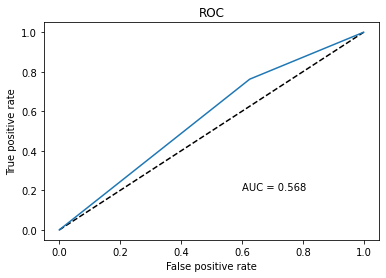

In [81]:
xgb_tuned.fit(x_train, y_train)
y_hat_xgb_tuned = xgb_tuned.predict(x_test)
evaluation(y_test, y_hat_xgb_tuned)

Let's use one of the coolest features of XGBoost: validation. We can track automatically the training and test error for each added tree (training round, epoch). Also, we can choose how many rounds without improvement on the metrics we can to keep, so that we avoid overfitting after many rounds of no improvement: `early_stopping_rounds`

In [82]:
eval_set = [(x_train, y_train), (x_test, y_test)]
xgb_tuned.fit(
    x_train, 
    y_train, 
    early_stopping_rounds=15, # How many rounds without improvement in our metric (error, auc) before we stop training
    eval_metric=["error", "auc"], # will check the error and the auc on each training round
    eval_set=eval_set, 
    verbose=1 # print each iteration
)

# retrieve performance metrics
results = xgb_tuned.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)

[0]	validation_0-error:0.34638	validation_0-auc:0.67276	validation_1-error:0.44397	validation_1-auc:0.51089
[1]	validation_0-error:0.32201	validation_0-auc:0.71029	validation_1-error:0.43740	validation_1-auc:0.54910
[2]	validation_0-error:0.32566	validation_0-auc:0.72541	validation_1-error:0.41861	validation_1-auc:0.57558
[3]	validation_0-error:0.31607	validation_0-auc:0.73221	validation_1-error:0.41544	validation_1-auc:0.56771
[4]	validation_0-error:0.30883	validation_0-auc:0.74024	validation_1-error:0.41657	validation_1-auc:0.56668
[5]	validation_0-error:0.30715	validation_0-auc:0.74248	validation_1-error:0.40638	validation_1-auc:0.56590
[6]	validation_0-error:0.30632	validation_0-auc:0.74337	validation_1-error:0.40525	validation_1-auc:0.56715
[7]	validation_0-error:0.30243	validation_0-auc:0.74423	validation_1-error:0.40254	validation_1-auc:0.57102
[8]	validation_0-error:0.30212	validation_0-auc:0.74625	validation_1-error:0.40299	validation_1-auc:0.57469
[9]	validation_0-error:0.302

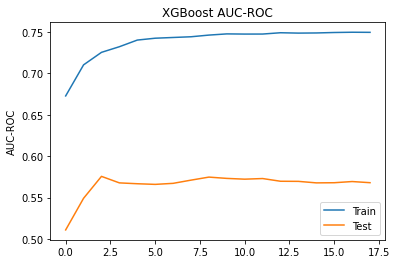

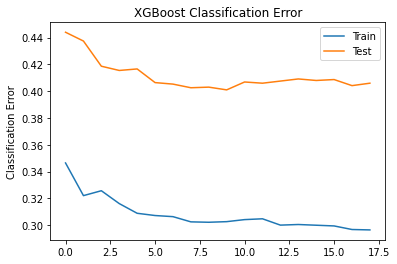

In [83]:
# plot auc
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['auc'], label='Train')
ax.plot(x_axis, results['validation_1']['auc'], label='Test')
ax.legend()
plt.ylabel('AUC-ROC')
plt.title('XGBoost AUC-ROC')
plt.show()

# plot classification error
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
plt.ylabel('Classification Error')
plt.title('XGBoost Classification Error')
plt.show()

It seems like it's already flat for AUC after the first 15 rounds, and since it's not improving, our `early_stopping` parameters has stopped the whole training. But what if we let the model train and then we decide the `early_stopping`?

In [85]:
eval_set = [(x_train, y_train), (x_test, y_test)]
xgb_tuned.fit(
    x_train, 
    y_train, 
    early_stopping_rounds=500, # How many rounds without improvement in our metric (error, auc) before we stop training
    eval_metric=["error", "auc"], # will check the error and the auc on each training round
    eval_set=eval_set, 
    verbose=0 # print each iteration
)

# retrieve performance metrics
results = xgb_tuned.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)

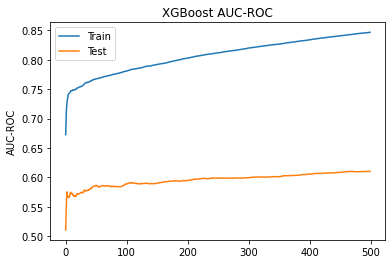

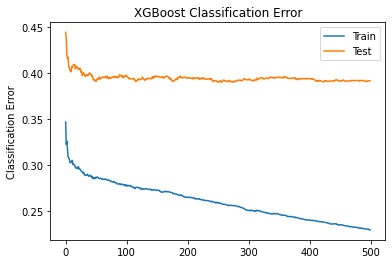

In [86]:
# plot auc
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['auc'], label='Train')
ax.plot(x_axis, results['validation_1']['auc'], label='Test')
ax.legend()
plt.ylabel('AUC-ROC')
plt.title('XGBoost AUC-ROC')
plt.show()

# plot classification error
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
plt.ylabel('Classification Error')
plt.title('XGBoost Classification Error')
plt.show()

Accuracy: 0.609
Precision: 0.650
Recall: 0.763
Confusion matrix:
[[ 653 1097]
 [ 631 2036]]


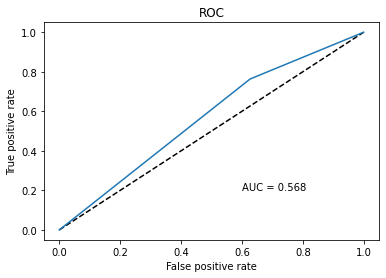

In [87]:
y_hat_xgb_tuned = xgb_tuned.predict(x_test)
evaluation(y_test, y_hat_xgb_tuned)

Sometimes, there's some noise in the first rounds and a smaller early stopping can make you miss the actual improvement of the training

It seems that the `AUC` still has a positive slope, we should add more trees and train for more rounds!

Now we'll try with 2000 trees

In [88]:
xgb_tuned = XGBClassifier(
    use_label_encoder=False, # labels are already encoded as [0, 1]
    objective='binary:logistic', # logistic regression for binary classification
    max_depth=5,  # depth of each tree
    subsample=0.3,  # sample of training data each tree will use
    n_estimators=2000,  # total number of trees that will be created
    learning_rate=0.01  # how much each tree will learn 
)

eval_set = [(x_train, y_train), (x_test, y_test)]
xgb_tuned.fit(
    x_train, 
    y_train, 
    early_stopping_rounds=500, # How many rounds without improvement in our metric (error, auc) before we stop training
    eval_metric=["error", "auc"], # will check the error and the auc on each training round
    eval_set=eval_set, 
    verbose=0 # print each iteration
)

# retrieve performance metrics
results = xgb_tuned.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)

Accuracy: 0.611
Precision: 0.657
Recall: 0.744
Confusion matrix:
[[ 714 1036]
 [ 684 1983]]


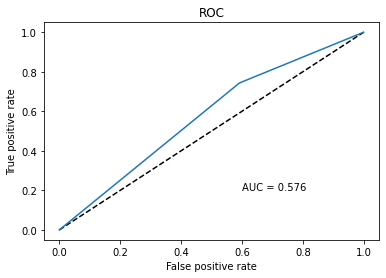

In [89]:
y_hat_xgb_tuned = xgb_tuned.predict(x_test)
evaluation(y_test, y_hat_xgb_tuned)

By using early stopping, the best model according to the test metrics is the one that will be saved after the training.

61.1 % Accuracy!

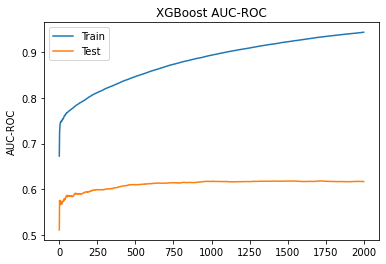

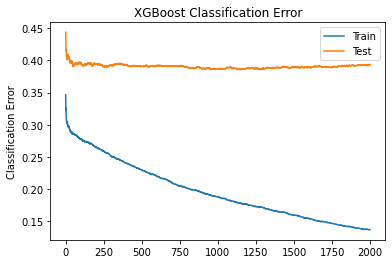

In [90]:
# plot auc
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['auc'], label='Train')
ax.plot(x_axis, results['validation_1']['auc'], label='Test')
ax.legend()
plt.ylabel('AUC-ROC')
plt.title('XGBoost AUC-ROC')
plt.show()

# plot classification error
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
plt.ylabel('Classification Error')
plt.title('XGBoost Classification Error')
plt.show()

In the end, we had `regularized` a lot by using a low`learning_rate`, and each tree only being allowed to grow to `max_depth`=5 while training with only a random sample of 30% of the training data, so adding more trees is a great idea in this case.

# Summary 

## Decision trees:
* Very prone to overfitting: control `max_depth`!
* Understandable results 
* Very good explainability (feature importance)

## Random Forest:
* Robust to overfitting if tuning the correct parameters (`n_estimators` and `max_features`)
* Less understandable results at first
* Good explainability (feature importance)

## XGBooooooooooost!
* Very robust to overfitting: use `early_stopping` to limit the learning rounds
* Needs longer training time but generally has better performance
* Good-ish explainability